In [1]:
import sys
import os
import math
import operator

sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.cpu_matcher import FlannMatcher
from autocnet.utils.utils import normalize_vector
from autocnet.matcher.deepen_funcs import dist_to_epipolar
from autocnet.camera.camera import compute_epipolar_line
from autocnet.control.control import ControlNetwork, identify_potential_overlaps
from autocnet.matcher.subpixel import clip_roi, subpixel_offset
import shapely.wkt as swkt
import geopandas as gpd

from scipy.spatial import KDTree

import networkx as nx
import pandas as pd
import random
from IPython.display import display

%pylab inline
figsize(20, 20)

Populating the interactive namespace from numpy and matplotlib


/Users/adampaquette/anaconda/envs/autocnet/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Point to the adjacency Graph
adjacency = get_path('cube_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(extractor_method='sift', extractor_parameters={'nfeatures':700})

#Match
cg.match()

#Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
cg.compute_fundamental_matrices(clean_keys=['symmetry', 'ratio'])

In [4]:
cg.create_control_network(clean_keys = ['fundamental'])

In [5]:
# ADDED
def get_x(y, m, b):
    return (m/y) - b

def get_y(x, m, b):
    return (m*x) + b

# This method is not going to work
def brute_force(keypoint, keypoints, edge, source, destination):
    if len(keypoint) >= 3:
        keypoint = keypoint[0:2]
    s_img = edge.source.geodata.read_array()
    d_img = edge.destination.geodata.read_array()
    strength_list = []
    if source < destination:
        template = clip_roi(s_img, keypoint, 19)
    else:
        template = clip_roi(d_img, keypoint, 19)
    for i in keypoints:
        if len(i) >= 3:
            i = i[0:2]
        if source < destination:
            search = clip_roi(d_img, i, 53)
        else:
            search = clip_roi(s_img, i, 53)
        try:
            _, _, strength = subpixel_offset(template, search)
            strength_list.append(strength)
        except:
            warnings.warn('Template-Search size mismatch, failing for this correspondence point.')
    all_strenght = pd.Series(data=strength_list)
    if any(all_strenght):
        print(all_strenght.max())
        return all_strenght.idxmax()
    else:
        return None

In [209]:
# ADDED
def find_match(keypoint_idx, keypoints, edge, source, destination, dist, func, *args, **kwargs):
    matches, mask = edge.clean(clean_keys = [])
    # Find potential good matches that were thrown out due to a check
    if source < destination:
        keypoint = edge.source.get_keypoint_coordinates(index = keypoint_idx, homogeneous=True).values
        # Use some function to limit the number of correspondences
        correspondences = func(keypoint, keypoints, edge, source, destination, *args, **kwargs)
        # Check if those correspondences exist as a match within some distance threshold
        kp_id_matches = matches.loc[matches['source_idx'] == keypoint_idx]
        edge_id_matches = kp_id_matches[kp_id_matches['destination_idx'].isin(correspondences)]
        dist_matches = edge_id_matches[edge_id_matches['distance'] < dist]
        # If there is some reasonable correspondence return the found match index
        if any(dist_matches):
            return matches.loc[dist_matches.loc[:, ['distance']].idxmin()].destination_idx.values
        else:
            subpixel_keypoints = edge.destination.get_keypoint_coordinates(index = correspondences).values
    else:
        # Same as above but all calculations are source, destination dependent
        keypoint = edge.destination.get_keypoint_coordinates(index = keypoint_idx, homogeneous=True).values
        correspondences = func(keypoint, keypoints, edge, source, destination, *args, **kwargs)
        kp_id_matches = matches.loc[matches['destination_idx'] == keypoint_idx]
        edge_id_matches = kp_id_matches[kp_id_matches['source_idx'].isin(correspondences)]
        dist_matches = edge_id_matches[edge_id_matches['distance'] < dist]
        if any(dist_matches):
            return matches.loc[dist_matches.loc[:, ['distance']].idxmin()].source_idx.values
        else:
            subpixel_keypoints = edge.source.get_keypoint_coordinates(index = correspondences).values
    return None

def source_to_dest(kp, source, destination, homogeneous = False):
    source_latlon = source.geodata.pixel_to_latlon(kp[0], kp[1])
    if homogeneous:
        return destination.geodata.latlon_to_pixel(source_latlon[0], source_latlon[1]) + (1,)
    else:
        return destination.geodata.latlon_to_pixel(source_latlon[0], source_latlon[1])
    
def dest_to_source(kp, source, destination, homogeneous = False):
    dest_latlon = destination.geodata.pixel_to_latlon(kp[0], kp[1])
    if homogeneous:
        return source.geodata.latlon_to_pixel(dest_latlon[0], dest_latlon[1]) + (1,)
    else:
        return source.geodata.latlon_to_pixel(dest_latlon[0], dest_latlon[1])

In [7]:
# ADDED
def nearest_neighbor(keypoint, keypoints, edge, source, destination, num_neighbors = 5):
    if source < destination:
        reproj_keypoint = source_to_dest(keypoint, edge.source, edge.destination, homogeneous=True)
    else:
        reproj_keypoint = dest_to_source(keypoint, edge.source, edge.destination, homogeneous=True)
    kd_tree = KDTree(data = keypoints)
    return kd_tree.query(reproj_keypoint, num_neighbors, eps = 2, p = 1)[1]

def dist_to_epipolar(keypoint, keypoints, edge, source, destination, geometric_threshold=.2):
    if source < destination:
        f_matrix = edge['fundamental_matrix'].T
    else:
        f_matrix = edge['fundamental_matrix']
    epipolar_line = compute_epipolar_line(keypoint, f_matrix) 
    bc_distance = np.abs(epipolar_line.dot(keypoints.T))
    return np.where(bc_distance < geometric_threshold)[0]    

def my_func(keypoint, keypoints, edge, source, destination, geometric_threshold=.05, num_neighbors = 5):
    nn_index = nearest_neighbor(keypoint, keypoints, edge, source, destination, num_neighbors)
    epipolar_index = dist_to_epipolar(keypoint, keypoints[nn_index], edge, source, destination, geometric_threshold)
    return nn_index[epipolar_index]

In [8]:
def point_eject(control_points):
    po_idx_list = []
    po_node_list = []
    po_keypoint_list = []
    po_edge_list = []
    
    for i, row in control_points.groupby('point_id').count().iterrows():
        control_point = np.asarray(control_points.query('point_id == ' + str(i)))[-1][0:4]
        po_idx_list.append(control_point[0])
        po_node_list.append((control_point[1], ))
        po_keypoint_list.append(np.asarray(control_point[2]))
        po_edge_list.append(control_point[3])
        
    return pd.Series(po_node_list, index=po_idx_list), po_keypoint_list, po_edge_list

def points_found(keypoint_indices, all_correspondences):
    keypoints_found = 0
    
    for i, j in enumerate(all_correspondences):
        if keypoint_indices[i] in j:
            keypoints_found += 1
        else:
            print(i, j)
            
    print(keypoints_found, len(keypoint_indices), (keypoints_found/len(keypoint_indices))*100)

In [208]:
def deepen_correspondences(cg, overlap, func=dist_to_epipolar, dist = 275, *args, **kwargs):
    # Get the candidates that lie within the overlap as an innitial mask
    candidates = identify_potential_overlaps(cg, cg.controlnetwork)
    all_measures = []
    # Loop through the candidates
    for i, j in enumerate(candidates):
        # Get the control point, "source", and keypoint for the candidate
        control_point = cg.controlnetwork.data.query('point_id == ' + str(candidates.index[i]))
        source = control_point.loc[control_point.index[0]].image_index
        kp_idx = control_point.loc[control_point.index[0]].keypoint_index
        # Loop over all potential images that should overlap
        for destination in j:
            # Create an edge based off of source and destination
            edge = cg.edge[source][destination]
            if source < destination:
                keypoints = edge.destination.get_keypoint_coordinates(homogeneous = True).values
            else:
                keypoints = edge.source.get_keypoint_coordinates(homogeneous = True).values
            new_correspondence = find_match(kp_idx, keypoints, edge, source, destination, dist, func, *args, **kwargs)
            # returns as source_idx, ..., destin_idx
            measure = [kp_idx, (source, destination), new_correspondence]
            all_measures.append(measure)
    return all_measures

In [210]:
# points = point_eject(cg.controlnetwork.data)
measures = deepen_correspondences(cg, True, dist = 200, func = my_func, geometric_threshold = .08, num_neighbors = 20)

/Users/adampaquette/autocnet/autocnet/graph/node.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  keypoints['homogeneous'] = 1


In [215]:
def plot_eline(edge, source, destin, source_kp_idx, destin_kp_idx, ax = None):
    """
    Plots an epipolar line with the source and destination images, along with the associated indicies
    of the keypoints.
    
    -->NOTE<--: source and destin have to be in the order that the epipolar line is computed. If you
    want an epipolar line from the 1, 0 edge on the 0 image source must be 1 and destination must be 0.
    The same is true for the source_kp_idx and destin_kp_idx, the source should be from 1 and the destination
    should be from 0
    Parameters
    ----------
    
    edge : object
           networkx edge object
           
    source : int
             The node id of the source image
             
    destination : int
                  The node if of the destination image
                  
    source_kp_idx : int
                    Source keypoint index
    
    destin_kp_idx : int
                    Destination keypoint index
                    
    ax : object
         A MatPlotLIb axes object
         
    Returns
    ----------
    ax : object
         A MatPlotLIb axes object. Either the argument passed in
         or a new object
    """
    
    if ax is None:
        ax = plt.gca()
    # Code "Borrowed" from plot_edge
    # with some hard coded values
    downsample_source = 1
    source_array = edge.source.get_array()

    downsample_destin = 1
    destination_array = edge.destination.get_array()
    
    s_shape = source_array.shape
    d_shape = destination_array.shape

    y = max(s_shape[0], d_shape[0])
    x = s_shape[1] + d_shape[1] + 100
    composite = np.zeros((y, x))

    composite[0: s_shape[0], :s_shape[1]] = source_array
    composite[0: d_shape[0], s_shape[1] + 100:] = destination_array
    
    r = lambda: random.uniform(0.0, 1.0)
    color = [r(), r(), r()]
    
    if not hasattr(source_kp_idx, '__iter__'):
        s_i = np.asarray([source_kp_idx])
    else:
        s_i = source_kp_idx
        
    if not hasattr(destin_kp_idx, '__iter__'):
        d_i = np.asarray([destin_kp_idx])
    else:
        d_i = destin_kp_idx
    
    # Compute the epipolar line deepending on the source and destination given
    if source < destin:
        keypoint = edge.source.get_keypoint_coordinates(index = s_i, homogeneous = True).values
        reproj_keypoint = source_to_dest(keypoint[0], edge.source, edge.destination)
        f_matrix = edge['fundamental_matrix'].T
    else:
        keypoint = edge.destination.get_keypoint_coordinates(index = d_i, homogeneous = True).values
        reproj_keypoint = dest_to_source(keypoint[0], edge.source, edge.destination)
        f_matrix = edge['fundamental_matrix']
        
    e_line = compute_epipolar_line(keypoint[0], f_matrix=f_matrix)
    m=(-(e_line[0]/e_line[1]))
    b=(-(e_line[2]/e_line[1]))
    
    ax.imshow(composite, cmap="Greys")
    
    ax.plot(edge.source.get_keypoint_coordinates(index = s_i).x, 
         edge.source.get_keypoint_coordinates(index = s_i).y, 
         markersize = 7, marker = '.', linewidth = 0, color = 'r')

    x_offset = s_shape[1] + 100  
    
    destin_coords = edge.destination.get_keypoint_coordinates(index = d_i)
    destin_xcoords = destin_coords.x + x_offset
    destin_ycoords = destin_coords.y
    
    e_line_x = np.asarray([0, d_shape[0]])
    e_line_y = np.asarray([get_y(0, m, b), get_y(500, m, b)])
    
    if source < destin:
        e_line_x = e_line_x + x_offset
        reproj_keypoint[0] = reproj_keypoint[0] + x_offset
        
    ax.plot(destin_xcoords, destin_ycoords,
         markersize = 7, marker = '.', linewidth = 0, color = 'r')
    
    ax.plot(e_line_x, e_line_y, 
         color = 'y', linewidth = 3, alpha = .3)
    ax.plot(reproj_keypoint[0], reproj_keypoint[1], 
         markersize = 7, marker = '.', linewidth = 0, color = 'b')
    
    return ax

[552.0, (1.0, 0), array([ 360.], dtype=float32)]


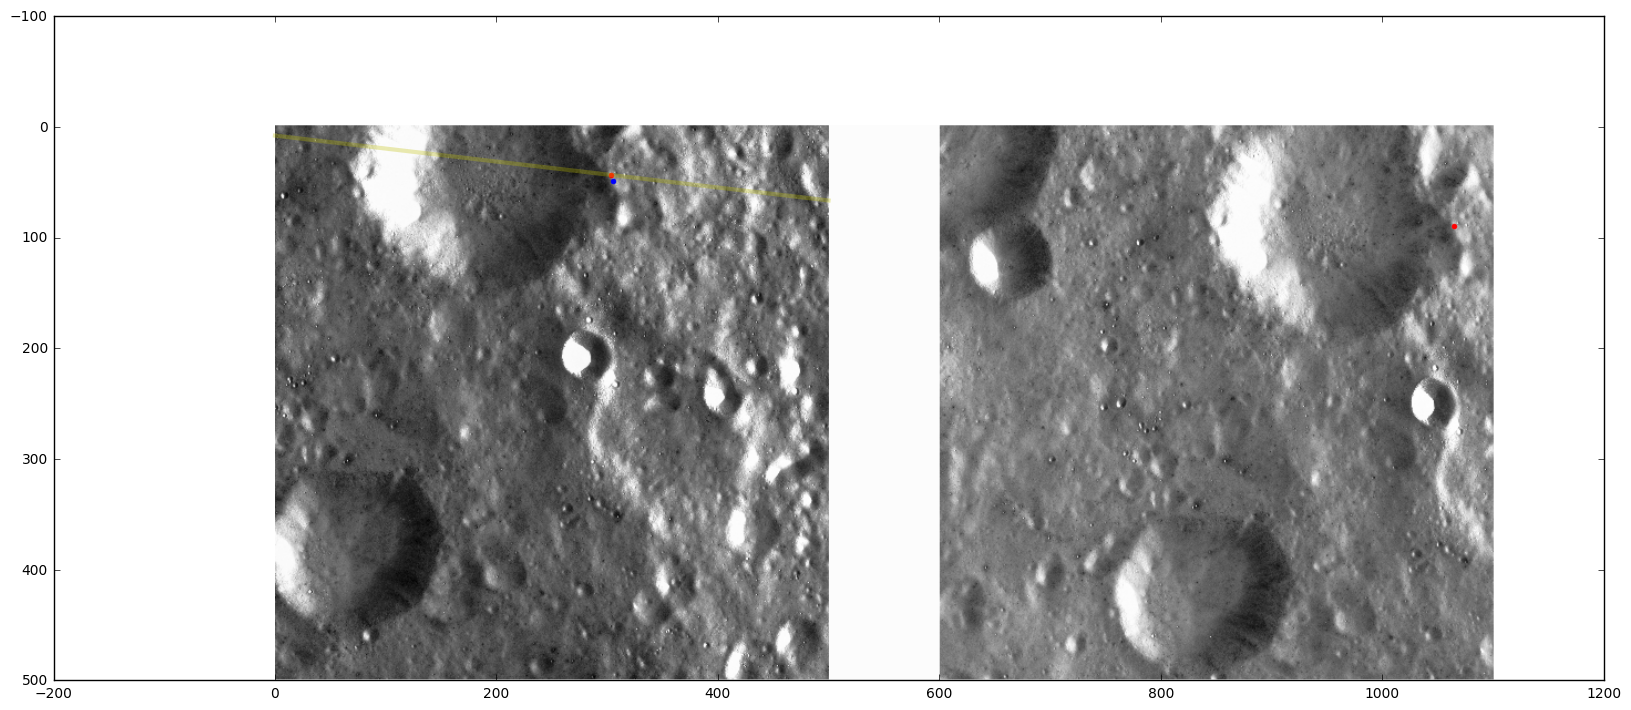

In [216]:
x = 2
y = 55
measure = measures[y]
print(measure)
edge = cg.edge[measure[1][0]][measure[1][1]]
source = measure[1][0]
destination = measure[1][1]
if source < destination:
    plot_eline(edge, measure[1][0], measure[1][1], measure[0], measure[2])
else:
    plot_eline(edge, measure[1][0], measure[1][1], measure[2], measure[0])
# plot_eline_s2d(edge, )

In [156]:
print(len(measures))
j = 0
for i, row in enumerate(measures):
    if row[2] is not None:
        source = row[1][0]
        destination = row[1][1]
        edge = cg.edge[source][destination]
        source_idx = row[0]
        destination_idx = row[2][0]
        if destination < source:
            temp = source_idx
            source_idx = destination_idx
            destination_idx = temp
        if j == 80:
            print(source, destination, source_idx, destination_idx)
            if source < destination:
                plot_eline_s2d(edge, source_idx, destination_idx)
            else:
                plot_eline_d2s(edge, source_idx, destination_idx)
        j += 1
print(j)

60


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
for i, row in enumerate(measures):
    if row[2] is not None:
        source = row[1][0]
        destination = row[1][1]
        edge = cg.edge[source][destination]
        source_idx = row[0]
        destination_idx = row[2][0]
        if destination < source:
            temp = source_idx
            source_idx = destination_idx
            destination_idx = temp
        f, (ax1, ax2) = plt.subplots(1,2)
        source_node = edge.source
        destin_node =edge.destination
        source_xy = source_node.get_keypoint_coordinates(index = source_idx)
        destin_xy = destin_node.get_keypoint_coordinates(index = destination_idx)
        ax1.imshow(source_node.geodata.read_array(pixels=[source_xy.x - 50, source_xy.y - 50, 100, 100]), cmap='Greys')
        ax2.imshow(destin_node.geodata.read_array(pixels=[destin_xy.x - 50, destin_xy.y - 50, 100, 100]), cmap='Greys')

        # Do your deepening here to get other_keypoint (whichever the algorithm thinks is correct)
#         other_keypoint = your_algos_best_guess
#         other_node = 
#         ax3.imshow(other_node.geodata.read_array(pixels=[other_keypoint.x - 50, other_keypoint.y-50, 100,100], cmap='Greys')
        show()

In [12]:
# For ploting a source > destination
def plot_eline_d2s(edge, source, destination):
    r = lambda: random.uniform(0.0, 1.0)
    color = [r(), r(), r()]
    s_i = np.asarray([source])
    d_i = np.asarray([destination])
    keypoint = edge.destination.get_keypoint_coordinates(index = d_i, homogeneous = True).values
    reproj_keypoint = dest_to_source(keypoint[0], edge.source, edge.destination)
    f_matrix = edge['fundamental_matrix']
    e_line = compute_epipolar_line(keypoint[0], f_matrix=f_matrix)
    m=(-(e_line[0]/e_line[1]))
    b=(-(e_line[2]/e_line[1]))
    distance_list = {}

    plt.figure(1)
    edge.source.plot(clean_keys = [], s = 50)
    plot(edge.source.get_keypoint_coordinates(index = s_i).x, edge.source.get_keypoint_coordinates(index = s_i).y, 
         markersize = 30, marker = '.', alpha = .7, linewidth = 0, color = color)
    plot([0, 500], [get_y(0, m, b), get_y(500, m, b)], 
         color = color, linewidth = 5, alpha = .3)
    plot(reproj_keypoint[0], reproj_keypoint[1], 
         markersize = 30, marker = '.', alpha = .7, linewidth = 0, color = color)

    plt.figure(2)
    edge.destination.plot(clean_keys = [], s = 50)
    plot(edge.destination.get_keypoint_coordinates().loc[d_i].x, 
         edge.destination.get_keypoint_coordinates().loc[d_i].y,
         markersize = 30, marker = '.', alpha = .7, linewidth = 0, color = color)

    # For ploting a source < destination 
def plot_eline_s2d(edge, source, destination):
    r = lambda: random.uniform(0.0, 1.0)
    color = [r(), r(), r()]
    s_i = np.asarray([source])
    d_i = np.asarray([destination])
    keypoint = edge.source.get_keypoint_coordinates(index = s_i, homogeneous = True).values
    reproj_keypoint = source_to_dest(keypoint[0], edge.source, edge.destination)
    f_matrix = edge['fundamental_matrix'].T
    e_line = compute_epipolar_line(keypoint[0], f_matrix=f_matrix)
    m=(-(e_line[0]/e_line[1]))
    b=(-(e_line[2]/e_line[1]))
    distance_list = {}

    plt.figure(1)
    edge.source.plot(clean_keys = [], s = 50)
    plot(edge.source.get_keypoint_coordinates().loc[s_i].x, edge.source.get_keypoint_coordinates().loc[s_i].y, 
         markersize = 30, marker = '.', alpha = .7, linewidth = 0, color = color)

    plt.figure(2)
    edge.destination.plot(clean_keys = [], s = 50)
    plot(edge.destination.get_keypoint_coordinates().loc[d_i].x, edge.destination.get_keypoint_coordinates().loc[d_i].y,
         markersize = 30, marker = '.', alpha = .7, linewidth = 0, color = color)
    plot([0, 500], [get_y(0, m, b), get_y(500, m, b)], color = color, linewidth = 5, alpha = .3)
    plot(reproj_keypoint[0], reproj_keypoint[1], 
         markersize = 30, marker = '.', alpha = .7, linewidth = 0, color = color)

In [ ]:
my_func_correspondences = deepen_correspondences(cg, True, func = my_func, geometric_threshold = .2, num_neighbors = 30)
# points_found(point_eject(cg.controlnetwork.data)[1], my_func_correspondences)
# for i in my_func_correspondences:
#     print(len(i))

In [ ]:
nn_correspondences = deepen_correspondences(cg, True, func = nearest_neighbor, num_neighbors = 20)
points_found(point_eject(cg.controlnetwork.data)[1], nn_correspondences)

In [ ]:
edge = cg.edge[0][2]
matches, mask = edge.clean(clean_keys = ['fundamental'])
# print(matches)
keypoints_list = []
e_keypoint_list = []
distance_list = []
m_list = []
b_list = []
for i in edge_dict[(0, 1)]:
    print(i)
    e_keypoint = cg.node[0].get_keypoint_coordinates(index = i, homogeneous = True).values
    e_keypoint_list.append(e_keypoint)

    f_matrix = edge['fundamental_matrix']
    
    e_line = compute_epipolar_line(e_keypoint, f_matrix=f_matrix)
    
    keypoints = cg.node[1].get_keypoint_coordinates(index = edge_dict[(0, 1)][i], homogeneous=True).values.T

    distance = np.abs(e_line.dot(keypoints))

    keypoints_list.append(keypoints)
    distance_list.append(distance)

    m_list.append(-(e_line[0]/e_line[1]))
    b_list.append(-(e_line[2]/e_line[1]))
    
plt.figure(1)
cg.node[1].plot(clean_keys = ['fundamental'])
j = 0
for i in keypoints_list:
    plt.figure(1)
    r = lambda: random.uniform(0.0, 1.0)
    color = [r(), r(), r()]
    plot(i[0], i[1], marker = '.', color = color, markersize = 25)
    plot([0, 500], [get_y(0, m_list[j], b_list[j]), get_y(500, m_list[j], b_list[j])], color = color, linewidth = 5)
    plt.figure(2)
    edge.plot_source(clean_keys = ['fundamental'])
    plot(e_keypoint_list[j][0], e_keypoint_list[j][1], color = color, markersize = 25, linewidth = 0, marker = '.')
    j += 1

In [ ]:
cg.compute_overlaps()
cg.overlap_checks()
matches, mask = cg.edge[0][1].clean(clean_keys = ['overlap'])
print(matches.head(20))
matches, mask = cg.edge[0][1].clean(clean_keys = ['fundamental'])
print(matches.head(10))

In [ ]:
edge = cg.edge[0][1]
kp = edge.destination.get_keypoint_coordinates(homogeneous=True).loc[8]
kps = edge.source.get_keypoint_coordinates(homogeneous = True).values
f_matrix = edge['fundamental_matrix'].T
index = add_point(kp, kps, dist_to_epipolar, compute_epipolar_line(f_matrix, kp), geometric_threshold = .2)
coords = kps[index]
print(coords)
# print(edge.source.get_keypoint_coordinates().loc[36])

In [ ]:
latlon_coords = edge.destination.geodata.pixel_to_latlon(edge.destination.get_keypoint_coordinates().loc[1].x,
                                                         edge.destination.get_keypoint_coordinates().loc[1].y)
print(edge.source.geodata.latlon_to_pixel(latlon_coords[0], latlon_coords[1]))
print(edge.source.get_keypoint_coordinates().loc[2])

In [ ]:
plt.figure(1)
edge.source.plot(clean_keys = 'fundamental', s = 50)
ax = plt.gca()
ax.scatter(coords.T[0], coords.T[1], s = 400, marker = '.', alpha = .5, color='b')
# plot(edge.source.get_keypoint_coordinates().loc[36].x, edge.source.get_keypoint_coordinates().loc[36].y)
plt.figure(2)
edge.destination.plot(clean_keys = 'fundamental', s = 50)
plot(edge.destination.get_keypoint_coordinates().loc[8].x, edge.destination.get_keypoint_coordinates().loc[8].y,
     markersize = 30, marker = '.', alpha = .5)

In [ ]:
# def deepen_correspondences(node, bc, keypoint_idx,
#                            clean_keys=[],
#                            geometric_threshold=2):

#     # Grab F for reprojection
#     f_matrix = bc['fundamental_matrix']

#     if f_matrix is None:
#         return None, None

#     # Compute the epipolar line projecting point ab into bc
#     ab_kp = node.get_keypoint_coordinates(homogeneous = True).loc[keypoint_idx]
#     epipolar_line = normalize_vector(ab_kp.dot(f_matrix.T))

#     # Check to see if a previously removed candidate fulfills the threshold geometric constraint
#     if node['node_id'] == edge.source['node_id']:
#         bc_candidates = bc.matches[(bc.matches['source_idx'] == keypoint_idx)]
#         bc_candidate_coords = bc.destination.get_keypoint_coordinates(index=bc_candidates['destination_idx'], 
#                                                                       homogeneous = True).values
# #         bc_candidate_coords = bc.destination.get_keypoint_coordinates(homogeneous = True).values
#     else:
#         bc_candidates = bc.matches[(bc.matches['destination_idx'] == keypoint_idx)]
#         bc_candidate_coords = bc.source.get_keypoint_coordinates(index=bc_candidates['source_idx'], 
#                                                                       homogeneous = True).values
# #         bc_candidate_coords = bc.source.get_keypoint_coordinates(homogeneous = True).values
    
#     bc_distance = np.abs(epipolar_line.dot(bc_candidate_coords.T))

#     # Get the matches
#     second_order_candidates = np.where(bc_distance < geometric_threshold)[0]

#     # In testing, every single valid second order candidate has a single, duplicated entry.
#     # That is, the correspondence has passed symmetry, but failed some other check.  Therefore,
#     # an additional descriptor distance check is omitted here.
#     if len(second_order_candidates) > 0:
#         coord_list = []
#         for i in second_order_candidates:
# #             new_match = bc_candidates.iloc[second_order_candidates[0]]
#             coord_list.append(bc_candidate_coords[i])
#         return coord_list
#     else:
#         return None, None